# 日経平均株価 週足 メディアン統計

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = "N225"
symbol = "^%s" % code
ticker = yf.Ticker(symbol)

In [4]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period="10y", interval="1wk")

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y = datetime.timedelta(days=365 * 3)
df = df0[df0.index >= dt_last - tdelta_3y]

In [5]:
dt = df.tail(1).index[0]
date_str = f"{dt.month:02d}{dt.day:02d}"
date_str

'1027'

## Moving Median

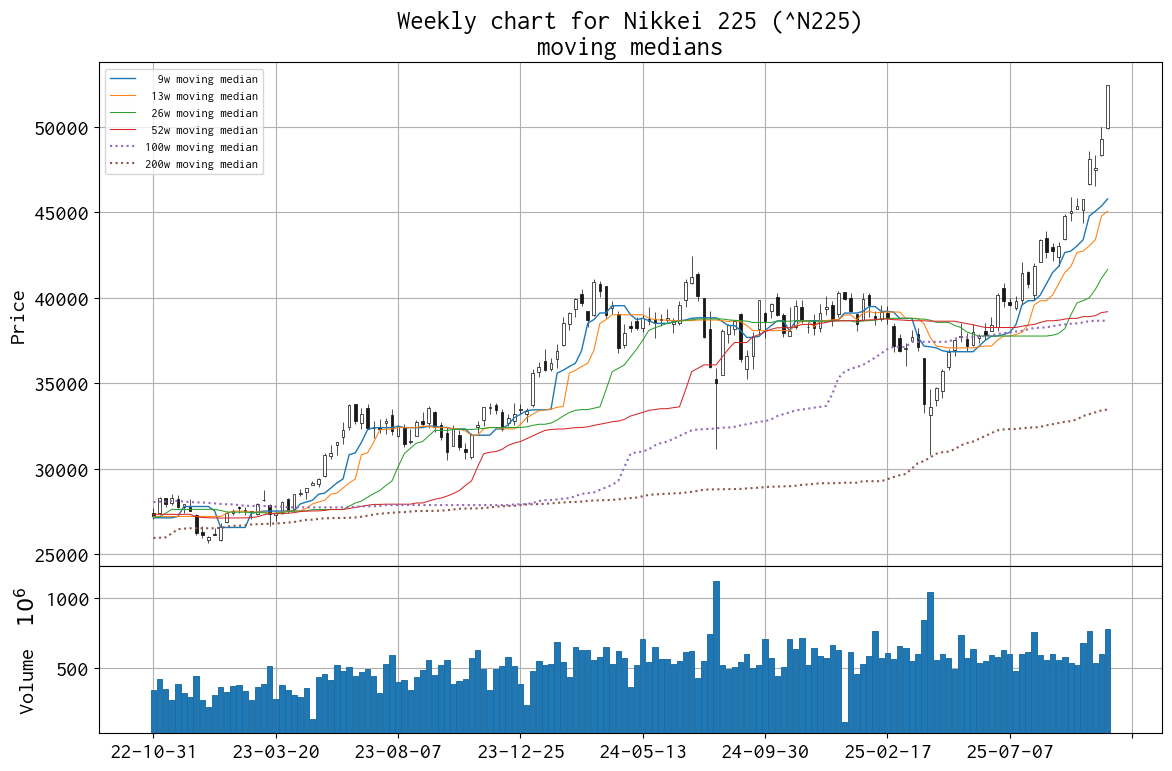

In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

mm09 = df0["Close"].rolling(9).median()
mm13 = df0["Close"].rolling(13).median()
mm26 = df0["Close"].rolling(26).median()
mm52 = df0["Close"].rolling(52).median()
mm100 = df0["Close"].rolling(100).median()
mm200 = df0["Close"].rolling(200).median()

apds = [
    mpf.make_addplot(mm09[df.index], width=1, label="  9w moving median", ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label=" 13w moving median", ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label=" 26w moving median", ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label=" 52w moving median", ax=ax[0]),
    mpf.make_addplot(
        mm100[df.index],
        width=1.5,
        linestyle="dotted",
        label="100w moving median",
        ax=ax[0],
    ),
    mpf.make_addplot(
        mm200[df.index],
        width=1.5,
        linestyle="dotted",
        label="200w moving median",
        ax=ax[0],
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    volume=ax[1],
    datetime_format="%y-%m-%d",
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

ax[0].set_title(
    f"Weekly chart for {ticker.info["longName"]} ({symbol})\nmoving medians"
)
ax[0].legend(loc="upper left", fontsize=9)

plt.tight_layout()
plt.savefig(f"{date_str}_report_weekly_chart_median_{code}.png")
plt.show()

In [7]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-10-20 00:00:00+09:00,48332.710938,49945.949219,48254.828125,49299.648438,603300000,0.0,0.0
2025-10-27 00:00:00+09:00,49905.800781,52411.339844,49838.980469,52411.339844,782500000,0.0,0.0


In [8]:
df.tail(2)["Close"]

Date
2025-10-20 00:00:00+09:00    49299.648438
2025-10-27 00:00:00+09:00    52411.339844
Name: Close, dtype: float64

In [9]:
df.tail(2)["Close"].diff()

Date
2025-10-20 00:00:00+09:00            NaN
2025-10-27 00:00:00+09:00    3111.691406
Name: Close, dtype: float64

In [10]:
df["Close"].rolling(9).median().tail(10)

Date
2025-08-25 00:00:00+09:00    41456.230469
2025-09-01 00:00:00+09:00    41820.480469
2025-09-08 00:00:00+09:00    42633.289062
2025-09-15 00:00:00+09:00    42718.468750
2025-09-22 00:00:00+09:00    43018.750000
2025-09-29 00:00:00+09:00    43378.308594
2025-10-06 00:00:00+09:00    44768.121094
2025-10-13 00:00:00+09:00    45045.808594
2025-10-20 00:00:00+09:00    45354.988281
2025-10-27 00:00:00+09:00    45769.500000
Name: Close, dtype: float64

In [11]:
df["Close"].rolling(13).median().tail(10)

Date
2025-08-25 00:00:00+09:00    40150.789062
2025-09-01 00:00:00+09:00    40799.601562
2025-09-08 00:00:00+09:00    41456.230469
2025-09-15 00:00:00+09:00    41820.480469
2025-09-22 00:00:00+09:00    42633.289062
2025-09-29 00:00:00+09:00    42718.468750
2025-10-06 00:00:00+09:00    43018.750000
2025-10-13 00:00:00+09:00    43378.308594
2025-10-20 00:00:00+09:00    44768.121094
2025-10-27 00:00:00+09:00    45045.808594
Name: Close, dtype: float64

In [12]:
df["Close"].rolling(26).median().tail(15)

Date
2025-07-21 00:00:00+09:00    37747.664062
2025-07-28 00:00:00+09:00    37747.664062
2025-08-04 00:00:00+09:00    37747.664062
2025-08-11 00:00:00+09:00    37747.664062
2025-08-18 00:00:00+09:00    37747.664062
2025-08-25 00:00:00+09:00    37793.984375
2025-09-01 00:00:00+09:00    37899.675781
2025-09-08 00:00:00+09:00    38184.166016
2025-09-15 00:00:00+09:00    38986.455078
2025-09-22 00:00:00+09:00    39690.279297
2025-09-29 00:00:00+09:00    39814.994141
2025-10-06 00:00:00+09:00    39984.949219
2025-10-13 00:00:00+09:00    40475.195312
2025-10-20 00:00:00+09:00    41127.916016
2025-10-27 00:00:00+09:00    41638.355469
Name: Close, dtype: float64

In [13]:
df["Close"].rolling(52).median().tail(10)

Date
2025-08-25 00:00:00+09:00    38639.265625
2025-09-01 00:00:00+09:00    38672.404297
2025-09-08 00:00:00+09:00    38739.419922
2025-09-15 00:00:00+09:00    38781.980469
2025-09-22 00:00:00+09:00    38781.980469
2025-09-29 00:00:00+09:00    38884.384766
2025-10-06 00:00:00+09:00    38884.384766
2025-10-13 00:00:00+09:00    38939.095703
2025-10-20 00:00:00+09:00    39120.300781
2025-10-27 00:00:00+09:00    39169.914062
Name: Close, dtype: float64

In [14]:
df0["Close"].rolling(100).median().tail(10)

Date
2025-08-25 00:00:00+09:00    38324.060547
2025-09-01 00:00:00+09:00    38383.750000
2025-09-08 00:00:00+09:00    38427.345703
2025-09-15 00:00:00+09:00    38469.349609
2025-09-22 00:00:00+09:00    38487.568359
2025-09-29 00:00:00+09:00    38542.183594
2025-10-06 00:00:00+09:00    38616.044922
2025-10-13 00:00:00+09:00    38639.265625
2025-10-20 00:00:00+09:00    38644.509766
2025-10-27 00:00:00+09:00    38646.929688
Name: Close, dtype: float64

In [15]:
df0["Close"].rolling(200).median().tail(5)

Date
2025-09-29 00:00:00+09:00    33069.800781
2025-10-06 00:00:00+09:00    33179.044922
2025-10-13 00:00:00+09:00    33283.230469
2025-10-20 00:00:00+09:00    33404.466797
2025-10-27 00:00:00+09:00    33447.841797
Name: Close, dtype: float64

## Robust Bollinger bands

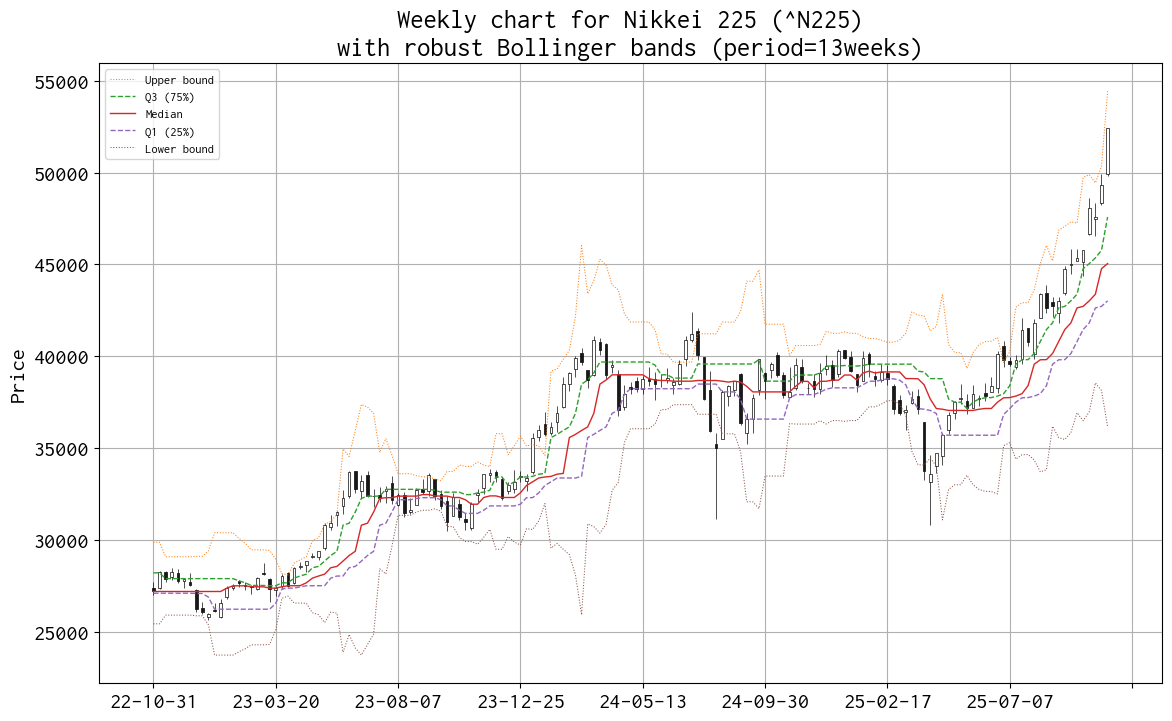

In [16]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(figsize=(12, 7.5))

# Bollinger bands
period = 13
mv_median = df0["Close"].rolling(period).median()
mv_q1 = df0["Close"].rolling(period).quantile(0.25)
mv_q3 = df0["Close"].rolling(period).quantile(0.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds = [
    mpf.make_addplot(
        mv_upper[df.index],
        width=0.75,
        color="C1",
        linestyle="dotted",
        label="Upper bound",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_q3[df.index],
        width=1,
        color="C2",
        linestyle="dashed",
        label="Q3 (75%)",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_median[df.index],
        width=1,
        color="C3",
        linestyle="solid",
        label="Median",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_q1[df.index],
        width=1,
        color="C4",
        linestyle="dashed",
        label="Q1 (25%)",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_lower[df.index],
        width=0.75,
        color="C5",
        linestyle="dotted",
        label="Lower bound",
        ax=ax,
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    addplot=apds,
    datetime_format="%y-%m-%d",
    xrotation=0,
    ax=ax,
)
#    fill_between=dict(y1=mv_q1[df.index].values,y2=mv_q3[df.index].values, color='blue'),
# ax.fill_between(df.index, y1=mv_q1[df.index].values, y2=mv_q3[df.index].values, color='blue')

ax.grid()
ax.legend(loc="best", fontsize=9)

try:
    ax.set_title(
        f"Weekly chart for {ticker.info['longName']} ({symbol})\nwith robust Bollinger bands (period={period}weeks)"
    )
except KeyError:
    ax.set_title(
        f"Weekly chart for {symbol}\nwith robust Bollinger bands (period={period}weeks)"
    )

plt.tight_layout()
plt.savefig(f"{date_str}_report_weekly_chart_bollinger_robust_{code}.png")
plt.show()

## ヒストグラムと Q-Q プロット

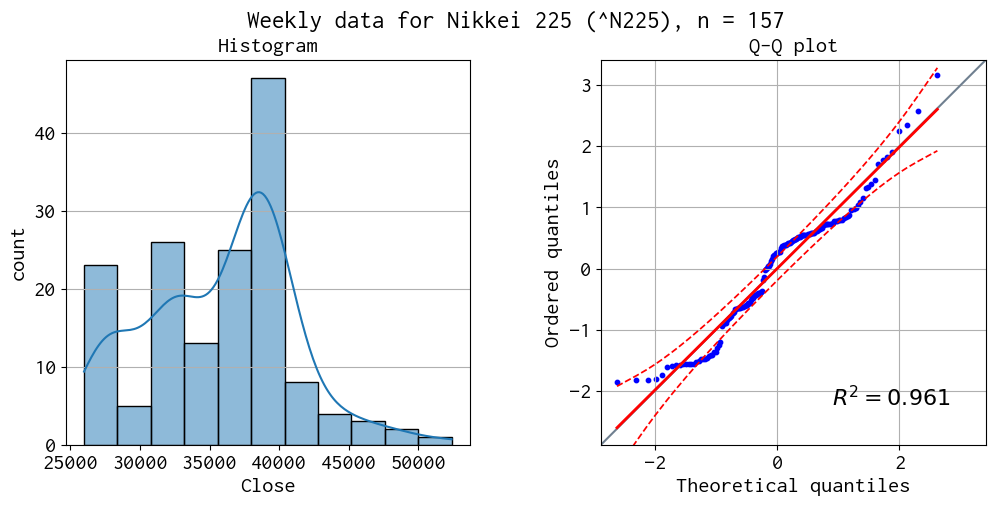

In [17]:
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["Close"], kde=True, ax=axes[0])

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis="y")
axes[0].set_title("Histogram", fontsize=16)

# Q-Q プロット
pg.qqplot(df["Close"], s=10, ax=axes[1])
axes[1].set_title("Q-Q plot", fontsize=16)
axes[1].grid()

plt.suptitle(
    "Weekly data for %s (%s), n = %d" % (ticker.info["longName"], symbol, len(df)),
    fontsize=18,
)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{date_str}_report_weekly_histogram_qqplot_{code}.png")
plt.show()